# Logistic Regression Model

## Data Import And Cleaning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import scripts.logistic_regression_functions as lrf
import scripts.helper_functions as hf

#reloads the module with the most recent updates
%load_ext autoreload
%aimport scripts.logistic_regression_functions, scripts.helper_functions
%autoreload 2

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_files = ['../../data/cleaned/utah_2017_vineyard.csv', 
               '../../data/cleaned/utah_2017_marina.csv']

test_files = ['../../data/cleaned/utah_2018_marina.csv',
               '../../data/cleaned/utah_2018_bird.csv']

drop_columns = ['Chlorophyll ug/L', 'Chlorophyll RFU', 'Wiper Pos V',
                'Cable Pwr V', 'Battery V', 'Chlorophyll (ug/L)', 'FDOM RFU']
x_columns = ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
            'ODOSat%', 'ODO (mg/L)']

target_column = 'BGA-Phycocyanin RFU'

# TODO Create average off of minor bloom
RFU_THRESHOLD = 1.2
train_index = 0
test_index = 0

In [3]:
# Load the data
train_dfs = lrf.import_df_data(train_files, drop_columns)
test_dfs = lrf.import_df_data(test_files, drop_columns)

train_dfs[train_index].head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4


In [4]:
test_dfs[test_index].head()

,Time America/Boise UTC-06:00,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,4/11/2018 10:30,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6
1,4/11/2018 10:45,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6
2,4/11/2018 11:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7
3,4/11/2018 11:15,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7
4,4/11/2018 11:30,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7


In [5]:
train_dfs[train_index].describe()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
count,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000
mean,18.488235,1933.564575,-116.806951,8.633415,58.129348,87.056980,8.179008,0.979511
std,6.134464,151.800551,8.973830,0.147231,54.622278,13.793755,1.278416,0.731423
min,5.630000,3.000000,-153.700000,7.930000,0.660000,62.800000,5.170000,0.000000
25%,12.700000,1848.000000,-120.800000,8.530000,29.850000,80.000000,7.260000,0.500000
50%,20.320000,1939.000000,-115.700000,8.650000,42.140000,83.200000,8.080000,0.900000
75%,23.630000,2070.000000,-112.100000,8.700000,65.795000,88.900000,9.250000,1.200000
max,28.570000,2164.000000,-76.500000,9.230000,636.700000,209.700000,16.170000,16.100000


In [6]:
test_dfs[test_index].describe()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
count,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000
mean,19.131184,1990.294607,-196.624329,8.922357,63.929067,90.057202,8.309566,1.459773
std,5.045367,230.743946,27.769024,0.357733,70.885989,17.627283,1.486747,1.311960
min,0.000000,0.000000,-284.000000,0.000000,-0.880000,0.000000,0.000000,-0.400000
25%,15.480000,1869.000000,-216.950000,8.730000,33.750000,79.100000,7.280000,0.600000
50%,20.190000,1958.000000,-192.000000,8.920000,48.380000,85.300000,8.010000,1.000000
75%,23.070000,2149.000000,-179.500000,9.100000,68.275000,95.300000,9.240000,1.700000
max,28.600000,2417.000000,0.000000,10.100000,1248.920000,245.500000,19.590000,21.100000


## Use Datetime Index

In [7]:
print(test_dfs[test_index].dtypes)
print(train_dfs[train_index].dtypes)

Time America/Boise UTC-06:00     object
Temp C                          float64
Sp Cond (uS/cm)                   int64
pH (mV)                         float64
pH                              float64
Turbidity (NTU)                 float64
ODOSat%                         float64
ODO (mg/L)                      float64
BGA-Phycocyanin RFU             float64
dtype: object
Date (mm.dd.yyyy)       object
Time 24hr               object
Temp C                 float64
Sp Cond (uS/cm)          int64
pH (mV)                float64
pH                     float64
Turbidity (NTU)        float64
ODOSat%                float64
ODO (mg/L)             float64
BGA-Phycocyanin RFU    float64
dtype: object


In [8]:
# We will need to engineer a datetime column for our 2017 data

# Create a single datetime column from the strings provided in our csv's
for i in range(0, len(train_dfs)):
    timestamp = train_dfs[i]['Date (mm.dd.yyyy)'] + ' '+ train_dfs[i]['Time 24hr']
    timestamp = pd.to_datetime(timestamp)
    train_dfs[i]['timestamp'] = timestamp
    train_dfs[i]['datetime'] = timestamp
    train_dfs[i] = train_dfs[i].set_index('timestamp')
    train_dfs[i] = train_dfs[i].drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
train_dfs[train_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00


In [9]:
# Now to datetime index our 2018 data
for i in range(0, len(test_dfs)):
    timestamp = pd.to_datetime(test_dfs[i]['Time America/Boise UTC-06:00'])
    test_dfs[i]['timestamp'] = timestamp
    test_dfs[i]['datetime'] = timestamp
    test_dfs[i] = test_dfs[i].set_index('timestamp')
    test_dfs[i] = test_dfs[i].drop(columns=['Time America/Boise UTC-06:00'])
test_dfs[test_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00


## Optimal Window Size
Here we will see how much window size effects the accuracy of the base model.

In [10]:
base_columns = ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)']

iteration_delta = pd.Timedelta(6, unit='h')
y_delta = pd.Timedelta(12, unit='h')
max_x_window = pd.Timedelta(7, unit='d') 
max_y_window = pd.Timedelta(2, unit='d')
current_y_window = pd.Timedelta(1, unit='d')
best_accuracy = 0
best_recall = 0
best_precision = 0
best_x_window = iteration_delta
best_y_window = current_y_window

max_iter = 25000
loss = "log"

while current_y_window <= max_y_window:
    current_x_window = current_y_window
    print("Current y window", current_y_window)
    while current_x_window <= max_x_window:
        # Windowize
        print("current x window", current_x_window)
        print("Windowizing 2017 data set:", train_index)
        train = hf.data_window_reduction(
            train_dfs[train_index], 'datetime', target_column, 
            x_win_size=current_x_window, y_win_size=current_y_window)
        print("Windowizing 2018 data set:", test_index)
        test = hf.data_window_reduction(
            test_dfs[test_index], 'datetime', target_column,
            x_win_size=current_x_window, y_win_size=current_y_window)
        print()
        
        #Add target columns
        lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)
        
        # Sort
        model = SGDClassifier(max_iter=max_iter, loss=loss)
        # Sort columns by accuracy
        accuracy, recall, precision, cm, predictions, _, _ = lrf.train_model( model, train, test, base_columns,'bloom' )
        print("accuracy", accuracy)
        print("recall", recall)
        print("precision", precision)
        print()
        if accuracy > best_accuracy:
            print("Better Accuracy Found")
            best_accuracy = accuracy
            best_recall = recall
            best_precision = precision
            best_x_window = current_x_window
            best_y_window = current_y_window
        current_x_window += iteration_delta
    current_y_window += y_delta


Current y window 1 days 00:00:00
current x window 1 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

accuracy 0.7478260869565218
recall 0.8592964824120602
precision 0.7434782608695653

Better Accuracy Found
current x window 1 days 06:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

accuracy 0.7739130434782608
recall 0.8663366336633663
precision 0.7743362831858407

Better Accuracy Found
current x window 1 days 12:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 da

Combining extractions...

accuracy 0.7648809523809523
recall 0.8556701030927835
precision 0.7649769585253456

current x window 6 days 12:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

accuracy 0.7767857142857143
recall 0.8190954773869347
precision 0.806930693069307

current x window 6 days 18:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

accuracy 0.7373134328358208
recall 0.8717948717948718
precision 0.7296137339055794

current x window 7 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining ex

accuracy 0.6994047619047619
recall 0.8676470588235294
precision 0.7051792828685259

current x window 6 days 06:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

accuracy 0.6835820895522388
recall 0.8793969849246231
precision 0.6809338521400778

current x window 6 days 12:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

accuracy 0.6895522388059702
recall 0.8774509803921569
precision 0.6937984496124031

current x window 6 days 18:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 

accuracy 0.6976047904191617
recall 0.8878504672897196
precision 0.7116104868913857

current x window 6 days 12:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

accuracy 0.7125748502994012
recall 0.8909952606635071
precision 0.7203065134099617

current x window 6 days 18:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

accuracy 0.6826347305389222
recall 0.8790697674418605
precision 0.7026022304832714

current x window 7 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 

In [11]:
print("accuracy", best_accuracy)
print("recall", best_recall)
print("precision", best_precision)
print(best_x_window)
print(best_y_window)

accuracy 0.8245614035087719
recall 0.8756218905472637
precision 0.8341232227488151
3 days 00:00:00
1 days 00:00:00


## Optimal Shift Size (Using Optimal Window Size)

In [12]:
base_columns = ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)']

iteration_delta = pd.Timedelta(1, unit='h')
max_shift = pd.Timedelta(24, unit='h')
shift = iteration_delta
best_accuracy = 0
best_recall = 0
best_precision = 0
best_shift = shift

max_iter = 25000
loss = "log"

while shift <= max_shift:
    # Windowize
    print("Current shift size:", shift)
    print("Windowizing 2017 data set:", train_index)
    train = hf.data_window_reduction(
        train_dfs[train_index], 'datetime', target_column, 
        x_win_size=best_x_window, y_win_size=best_y_window,
        shift=shift)
    print("Windowizing 2018 data set:", test_index)
    test = hf.data_window_reduction(
        test_dfs[test_index], 'datetime', target_column,
        x_win_size=best_x_window, y_win_size=best_y_window,
        shift=shift)
    print()

    #Add target columns
    lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)

    # Sort
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    # Sort columns by accuracy
    accuracy, recall, precision, cm, predictions, _, _ = lrf.train_model( model, train, test, base_columns,'bloom' )
    print("accuracy", accuracy)
    print("recall", recall)
    print("precision", precision)
    print()
    if accuracy > best_accuracy:
        print("Better Accuracy Found")
        best_accuracy = accuracy
        best_recall = recall
        best_precision = precision
        best_shift = shift
    shift += iteration_delta


Current shift size: 0 days 01:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

accuracy 0.794640988067825
recall 0.8908829863603733
precision 0.7856916745805634

Better Accuracy Found
Current shift size: 0 days 02:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

accuracy 0.8007534533277522
recall 0.8874551971326164
precision 0.7951188182402055

Better Accuracy Found
Current shift size: 0 days 03:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
E

Extracting target windows...
Combining extractions...

accuracy 0.8256880733944955
recall 0.889763779527559
precision 0.8248175182481752

Better Accuracy Found
Current shift size: 0 days 23:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

accuracy 0.8028846153846154
recall 0.9008264462809917
precision 0.7898550724637681

Current shift size: 1 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

accuracy 0.8
recall 0.9009009009009009
precision 0.7751937984496124



In [13]:
print("accuracy", best_accuracy)
print("recall", best_recall)
print("precision", best_precision)
print("shift", best_shift)

accuracy 0.8256880733944955
recall 0.889763779527559
precision 0.8248175182481752
shift 0 days 22:00:00


## Segment data set based on new shift and window sizes

In [14]:
# Segment each data frame
print("Windowizing 2017 data set:", train_index)
train_dfs[train_index] = hf.data_window_reduction(
    train_dfs[train_index], 'datetime', target_column, 
    x_win_size=best_x_window, y_win_size=best_y_window,
    shift=best_shift)
print("Windowizing 2018 data set:", test_index)
test_dfs[test_index] = hf.data_window_reduction(
    test_dfs[test_index], 'datetime', target_column,
    x_win_size=best_x_window, y_win_size=best_y_window,
    shift=best_shift)

Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...


## Logistic Regression Model

In [15]:
lrf.add_target_column([train_dfs[train_index], test_dfs[test_index]], 
                      threshold=RFU_THRESHOLD)

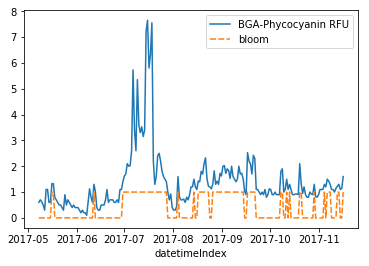

In [16]:
sns.lineplot(data=train_dfs[train_index][[target_column, 'bloom']], hue='bloom')

In [17]:
# The null model's performance
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, _, _, _ = lrf.train_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom', True)
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)
print("columns:", train_dfs[train_index].columns)

Accuracy 0.41743119266055045
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[ 91   0]
 [127   0]]
columns: Index(['BGA-Phycocyanin RFU', 'ODO (mg/L)', 'ODOSat%', 'Sp Cond (uS/cm)',
       'Temp C', 'Turbidity (NTU)', 'datetime', 'pH', 'pH (mV)', 'bloom'],
      dtype='object')


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)
# Sort columns by accuracy
sorted_columns = lrf.sort_columns_by_metric(model, train_dfs[train_index], 
                                            test_dfs[test_index],
                                            x_columns,
                                            'bloom')

Training model with: Temp C
Accuracy 0.6100917431192661
Recall: 0.44881889763779526
Precision 0.7916666666666666
Confusion Matrix:
 [[76 15]
 [70 57]]

Training model with: Sp Cond (uS/cm)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.41743119266055045
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[ 91   0]
 [127   0]]

Training model with: pH (mV)
Accuracy 0.5825688073394495
Recall: 1.0
Precision 0.5825688073394495
Confusion Matrix:
 [[  0  91]
 [  0 127]]

Training model with: pH
Accuracy 0.6788990825688074
Recall: 0.9133858267716536
Precision 0.6628571428571428
Confusion Matrix:
 [[ 32  59]
 [ 11 116]]

Training model with: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.41743119266055045
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[ 91   0]
 [127   0]]

Training model with: ODOSat%
Accuracy 0.7477064220183486
Recall: 0.7244094488188977
Precision 0.8214285714285714
Confusion Matrix:
 [[71 20]
 [35 92]]

Training model with: ODO (mg/L)
Accuracy 0.7431192660550459
Recall: 0.7559055118110236
Precision 0.7933884297520661
Confusion Matrix:
 [[66 25]
 [31 96]]

ODOSat% metric value: 0.7477064220183486
ODO (mg/L) metric value: 0.7431192660550459
pH metric value: 0.6788990825688074
Temp C metric value: 0.6100917431192661
pH (mV) metric value: 0.5825688073394495
Sp Cond (uS/cm) metric value: 0.41743119266055045
Turbidity (NTU) metric value: 0.41743119266055045


In [19]:
#create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)

accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.greedy_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 
                                            'bloom', sorted_columns)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'pH (mV)', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'pH (mV)', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['ODOSat%']
Test model accuracy: 0.7477064220183486
Test model recall: 0.7244094488188977
Test model precision: 0.8214285714285714

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.7798165137614679
Test model recall: 0.7952755905511811
Test model precision: 0.8211382113821138

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH']
Test model accuracy: 0.7706422018348624
Test model recall: 0.8661417322834646
Test model precision: 0.7692307692307693

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Temp C']
Test model accuracy: 0.7752293577981652
Test model recall: 0.7952755905511811
Test model precision: 0.8145161290322581

Training model with: ['ODOSat%', 'ODO (mg/L)

Model AUC: 0.8834


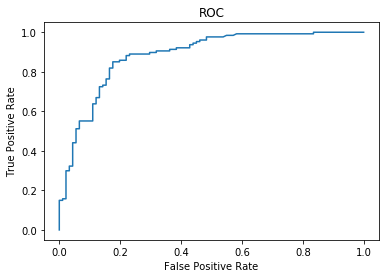

In [20]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test_dfs[test_index][['bloom']].values, predictions)

## Random Forest Model

In [21]:
# All Inputs
model = RandomForestClassifier(n_estimators=100)
accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.train_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)

Accuracy 0.7110091743119266
Recall: 0.937007874015748
Precision 0.6839080459770115
Confusion Matrix:
 [[ 36  55]
 [  8 119]]


Model AUC: 0.7531


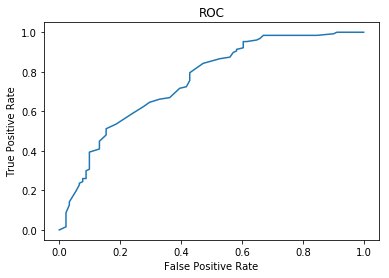

In [22]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test_dfs[test_index][['bloom']].values, predictions)